# ⚛️ H₃⁺ VQE — Fermion-to-Qubit Mapping Comparison (Noiseless)

This notebook compares **fermion-to-qubit mappings** for the H₃⁺ molecular
Hamiltonian under a **fixed UCCSD ansatz** and a **noiseless VQE simulation**.

We vary *only* the mapping:

- **Jordan–Wigner**  
- **Bravyi–Kitaev**  
- **Parity**  

Everything else is held constant:

- Geometry (slightly distorted triangular H₃⁺)  
- Electrons: 2  
- Basis: STO-3G  
- Ansatz: UCCSD (singles + doubles)  
- Optimizer: Adam  
- Device: `default.qubit`  

---
## 🎯 Goals

For each mapping, we compute:

1. **Hamiltonian complexity** (Pauli term count)  
2. **VQE convergence trace**  
3. **Final ground-state energy**  

This helps quantify how different encodings affect:

- circuit depth  
- optimization behaviour  
- resource requirements  

— all while keeping the chemistry and ansatz fixed.

---

In [1]:
# Core stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import sys, os, json, time

# Local imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    ensure_dirs,
    build_run_filename,
)

ensure_dirs()

# 🔧 Part A — Build H₃⁺ Hamiltonians (JW, BK, Parity)

We slightly distort the equilateral H₃⁺ geometry to avoid perfect symmetry,
which makes the comparison more representative.

For each mapping we store:

- Qubit Hamiltonian  
- Qubit count  
- Number of Pauli terms (complexity metric)  


In [2]:
set_seed(0)

# Distorted H₃⁺ geometry (Å)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [ 0.0,      1.0,    0.0],
    [-0.866025, -0.5,   0.0],
    [ 0.800000, -0.3,   0.0],
])
basis = "STO-3G"
charge = +1
electrons = 2

mappings = ["jordan_wigner", "bravyi_kitaev", "parity"]

hamiltonians = {}
qubits_required = {}
pauli_terms = {}

for mapping in mappings:
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=charge,
        basis=basis,
        mapping=mapping,
        active_electrons=electrons,
    )
    hamiltonians[mapping] = H
    qubits_required[mapping] = n_qubits
    pauli_terms[mapping] = len(H)

    print(f"{mapping:>15}: {len(H)} Pauli terms, {n_qubits} qubits")

  jordan_wigner: 118 Pauli terms, 6 qubits
  bravyi_kitaev: 118 Pauli terms, 6 qubits
         parity: 118 Pauli terms, 6 qubits


# 🧩 Part B — UCCSD Ingredients (Shared Across Mappings)

All mappings must use the **same ansatz**, built from:

- HF reference  
- Same set of single excitations  
- Same set of double excitations  

The only difference is how the fermionic Hamiltonian is **encoded**.

In [3]:
# Use Jordan–Wigner qubit count for HF state & excitations
qubits = qubits_required["jordan_wigner"]
hf_state = qchem.hf_state(electrons, qubits)

singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]

print(f"HF state = |{''.join(str(b) for b in hf_state)}⟩")
print(f"Singles = {len(singles)}, Doubles = {len(doubles)}")

HF state = |110000⟩
Singles = 4, Doubles = 4


# 🚀 Part C — Cache-Aware VQE for Each Mapping

A helper function:

- constructs a `default.qubit` device  
- builds the UCCSD cost function  
- performs an Adam optimization  
- handles caching via config hashing  

Only the Hamiltonian changes per mapping.

In [4]:
def run_mapping_with_cache(mapping, stepsize=0.2, max_iter=50):
    """Run VQE for a given mapping (or load from cache)."""
    H = hamiltonians[mapping]
    n_qubits = qubits_required[mapping]

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def cost_fn(params):
        excitation_ansatz(
            params,
            wires=range(n_qubits),
            hf_state=hf_state,
            excitations=(singles, doubles),
            excitation_type="both",  # UCCSD
        )
        return qml.expval(H)

    optimizer_name = "Adam"
    ansatz_desc = f"UCCSD (mapping={mapping})"

    # Build run config
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=0,
    )
    cfg["mapping"] = mapping

    sig = run_signature(cfg)
    fname = build_run_filename(f"H3plus_Mapping_{mapping}", optimizer_name, 0, sig)
    existing = find_existing_run(sig)

    # Load cached run if available
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {mapping}: {existing}")
        return rec["energies"]

    # Fresh run
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    energies = [float(cost_fn(params))]
    for _ in range(max_iter):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(float(e_prev))

    # Final energy recomputed for accuracy
    energies[-1] = float(cost_fn(params))

    rec = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3plus",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": n_qubits,
        "mapping": mapping,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iter,
            "iterations_ran": len(energies) - 1,
        },
        "seed": 0,
        "energies": energies,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
        "metadata": {"pauli_terms": pauli_terms[mapping]},
    }

    save_run_record(fname, rec)
    print(f"[saved] {mapping}: {fname}")
    return energies

# 📉 Part D — Run All Mappings & Plot Convergence

In [5]:
results = {}
for mapping in mappings:
    print(f"\n> Running mapping = {mapping}")
    results[mapping] = run_mapping_with_cache(mapping, stepsize=0.2, max_iter=50)


> Running mapping = jordan_wigner
[reuse] jordan_wigner: /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Mapping_jordan_wigner_Adam_s0__bf6390d6c44d.json

> Running mapping = bravyi_kitaev
[reuse] bravyi_kitaev: /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Mapping_bravyi_kitaev_Adam_s0__01928c44d93b.json

> Running mapping = parity
[reuse] parity: /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H3plus_Mapping_parity_Adam_s0__ac9ac4ecc97a.json


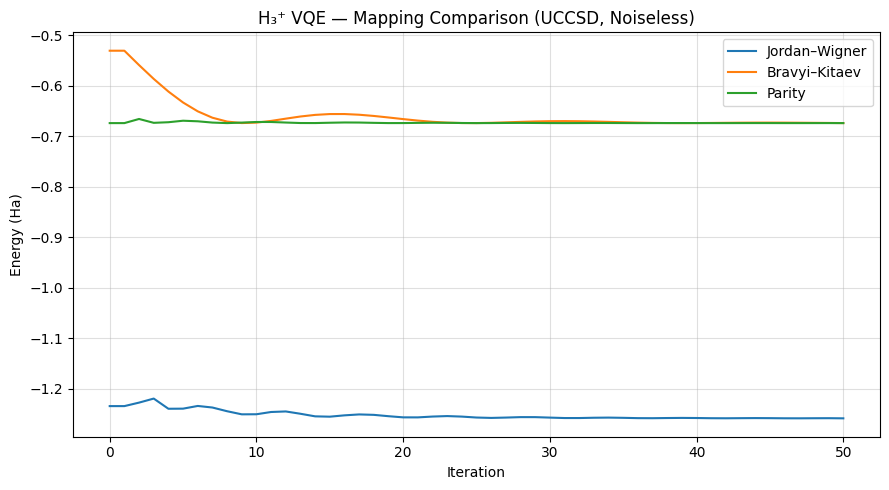

In [6]:
label_map = {
    "jordan_wigner": "Jordan–Wigner",
    "bravyi_kitaev": "Bravyi–Kitaev",
    "parity": "Parity",
}

plt.figure(figsize=(9, 5))
for mapping in mappings:
    plt.plot(results[mapping], label=label_map[mapping])

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — Mapping Comparison (UCCSD, Noiseless)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()

out = os.path.join(IMG_DIR, "H3plus_Mapping_Comparison.png")
plt.savefig(out, dpi=300)
plt.show()

# 📊 Part E — Final Energies & Best Mapping

In [7]:
print("\nFinal energies (last iteration):")
final_E = {}

for mapping in mappings:
    E = results[mapping][-1]
    final_E[mapping] = E
    print(f"{mapping:>15}: {E:.8f} Ha   ({pauli_terms[mapping]} Pauli terms)")

best = min(final_E, key=final_E.get)
print(f"\n🏆 Best mapping: {best}   →   E = {final_E[best]:.8f} Ha")


Final energies (last iteration):
  jordan_wigner: -1.25867803 Ha   (118 Pauli terms)
  bravyi_kitaev: -0.67410221 Ha   (118 Pauli terms)
         parity: -0.67413491 Ha   (118 Pauli terms)

🏆 Best mapping: jordan_wigner   →   E = -1.25867803 Ha
